In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [281]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)


In [282]:
data_path = './datasets/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

In [283]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)


In [284]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)


In [285]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [286]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [287]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.relu = nn.Tanh()
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 512
model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [288]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims, hidden_dims, output_dims).to(device)

In [289]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [290]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    return correct / len(y_true)

In [291]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
            
            val_predict.append(outputs.detach().cpu())
            val_target.append(y_samples.cpu())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.3f}, Validation loss: {val_loss:.3f}')


Epoch 1/100, Train Loss: 1.035, Validation loss: 1.038
Epoch 2/100, Train Loss: 1.033, Validation loss: 1.036
Epoch 3/100, Train Loss: 1.031, Validation loss: 1.035
Epoch 4/100, Train Loss: 1.027, Validation loss: 1.034
Epoch 5/100, Train Loss: 1.026, Validation loss: 1.032
Epoch 6/100, Train Loss: 1.026, Validation loss: 1.031
Epoch 7/100, Train Loss: 1.022, Validation loss: 1.031
Epoch 8/100, Train Loss: 1.019, Validation loss: 1.030
Epoch 9/100, Train Loss: 1.017, Validation loss: 1.029
Epoch 10/100, Train Loss: 1.016, Validation loss: 1.028
Epoch 11/100, Train Loss: 1.015, Validation loss: 1.028
Epoch 12/100, Train Loss: 1.017, Validation loss: 1.027
Epoch 13/100, Train Loss: 1.014, Validation loss: 1.026
Epoch 14/100, Train Loss: 1.013, Validation loss: 1.026
Epoch 15/100, Train Loss: 1.011, Validation loss: 1.026
Epoch 16/100, Train Loss: 1.012, Validation loss: 1.025
Epoch 17/100, Train Loss: 1.007, Validation loss: 1.025
Epoch 18/100, Train Loss: 1.006, Validation loss: 1.024
E

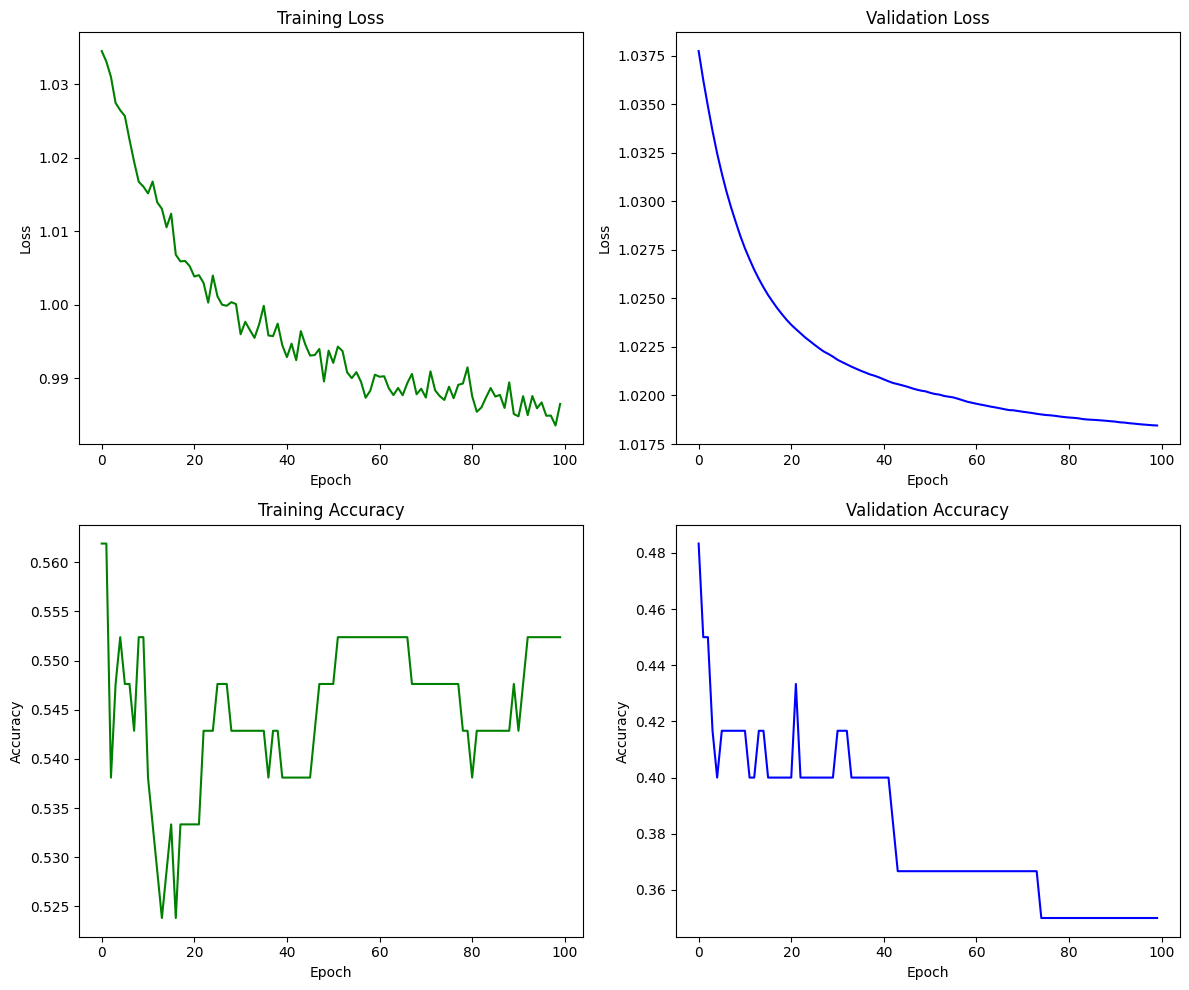

In [292]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss', title='Training Loss')

ax[0, 1].plot(val_losses, color='blue')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss', title='Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy', title='Training Accuracy')

ax[1, 1].plot(val_accs, color='blue')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy', title='Validation Accuracy')

plt.tight_layout()
plt.show()

In [293]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)
        
        test_predict.append(outputs.detach().cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)
print(f'Test Accuracy: {test_acc:.3f}')

Test Accuracy: 0.567
